In [1]:
#viola jones libraries
import json
import xmltodict
import math
import skimage.io as io
import skimage as sk
import cv2 as cv
import numpy as np
from cmath import sqrt
#from commonfunctions import *
from PIL import Image as im

#Emotion detection libraries
import matplotlib.pyplot as plt
import skimage.io as io
from scipy import signal as sig
# this a custom module found the commonfunctions.
import pywt
from scipy.stats import skew, kurtosis
from skimage.measure import shannon_entropy
from skimage.morphology import dilation
from scipy import ndimage
from scipy.signal import wiener
from scipy.fftpack import dct

from numba import jit
from math import ceil


#from Rect import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

Utility functions for image preprocessing

For variance normalization
we need:
1- integral of the image
2- integral of the square of the image
3- calulate the the varia

var=mean^2 -1/N(sum(X^2))

In [2]:
#var=mean^2 -1/N(sum(X^2))
def calculateVariance(window,sqrdWindow):
    #Calculate mean value of the image and square it
    #sqrdMean=(np.mean(window))**2
    mean=((window[1][1]+window[-1][-1]-window[1][-1]-window[-1][1])/np.size(window))
    
    #Sum of pixels in integral of the squared image
    #sqrdSum=np.sum(sqrdWindow)
    sqrdSum=(sqrdWindow[1][1]+sqrdWindow[-1][-1]-sqrdWindow[1][-1]-sqrdWindow[-1][1])
    
    #Number of pixels in the window
    N=np.size(window)
    
    #Calculated variance
    variance=(sqrdSum/N)-(mean*mean)
    
    #Normalize the window and return it
    # normalizedWindow=window*variance

    return variance

In [3]:
#calculate integral of the image(to be updated for better optimization)
# def integrateImage(img,i,j,cum):
def integrateImage(img):    
   
    rows=img.shape[0]
    cols=img.shape[1]
    integralImage=np.zeros((rows+1,cols+1))
    integralImage[1:,1:]=np.cumsum(img,1)
    integralImage=np.cumsum(integralImage,0)
        
        
    # return outputImage[i][j]
    return integralImage


In [4]:

# img=np.array([[1,2,2,4,1],[3,4,1,5,2],[2,3,3,2,4],[4,1,5,4,6],[6,3,2,1,3]])
# print(img)

# integralImage=integrateImage(img)
# sqrdImage=np.square(img)
# sqrdIntegralImage=integrateImage(sqrdImage)

# variance1=calculateVariance(integralImage,sqrdIntegralImage)
# variance2=np.var(img)

# print(integralImage)

# # print(img)



In [5]:
# window=np.ones((24,24))

# normalizedImagee=varianceNormalize(window,np.square(window))

Rect class

In [6]:
#x=cols
#y=rows
class Rect:
    def __init__(self,inputText,y1=0,x1=0,width=0,height=0,weight=0.0,x2=0,y2=0):
        splitInput = inputText.split(" ")
        
        self.x1=int(splitInput[0])-1
        self.y1=int(splitInput[1])-1
        
        
        
        self.width=int(splitInput[2])
        self.height=int(splitInput[3])
     
        self.weight=float(splitInput[4])    
        
        self.y2=self.y1+self.height
        self.x2=self.x1+self.width    
        

    def calculateArea(self,window,scale):
        #self.printRect()
       # print("window values: ",window[self.y2][self.x2],window[self.y1][self.x1],window[self.y1][self.x2],window[self.y2][self.x1])
        scaledX1=self.x1*scale
        scaledY1=self.y1*scale
        scaledY2=self.y2*scale
        scaledX2=self.x2*scale
        area=(window[scaledY2][scaledX2]+window[scaledY1][scaledX1]-window[scaledY1][scaledX2]-window[scaledY2][scaledX1])
       # print("weight*area/size: ",(self.weight*area)/(np.size(window)))
        #return (self.weight*area)/((window[0][0]+window[-1][-1]-window[0][-1]-window[-1][-0]))
        return (self.weight*area)/np.size(window)
    
    def printRect(self):
        print('Rect')
        print('x1: ',self.x1)
        print('x2: ',self.x2)
        print('y1: ',self.y1)
        print('y2: ',self.y2)
        print('width: ',self.width)
        print('height: ',self.height)
        print('weight: ',self.weight)
     

In [7]:
# text='1 8 19 12 -1.'
# rectangle=Rect(text)

# img=io.imread('coffee.jpeg',as_gray=True)
# integralImage=integrateImage(img)
# window=integralImage[0:23,0:23]

# text1='6 4 12 9 -1.'
# rectangle1=Rect(text1)
# area1=rectangle1.calculateArea(window)


# text2='6 7 12 3 3.'
# rectangle2=Rect(text2)
# area2=rectangle2.calculateArea(window)

# print(area1)
# print(area2)

Feature class 

In [8]:
#A feature is equivalent to tree node
#Each node has a value(sum of the pixels inside the rectangles).
#Either a left or a right value is returned based on the comparison with the threshold.
class Feature:    
     def __init__(self,leftValue,rightValue,threshold,rects):
          self.leftValue=leftValue
          self.rightValue=rightValue
          self.threshold=threshold
          self.rects=rects
        
     
     #Calculate initial value of the feature(two or three rectangle value)
     def calculateValue(self,window,scale):
          initialValue=0
          for i in range(0,len(self.rects)):
               initialValue+=self.rects[i].calculateArea(window,scale)
          return initialValue
     
     #weak classifier
     def classify(self,window,variance,scale):
          
          value=self.calculateValue(window,scale)
          if(value>self.threshold*variance):
              # print('feature right value after weak classifier:',self.rightValue)
               return self.rightValue
          else:
              # print('feature left value after weak classifier:',self.leftValue)
               return self.leftValue
          
     def printFeature(self):
          print('Feature: ')
          print('Left value: ',self.leftValue)
          print('Right value: ',self.rightValue)
          print('Threshold: ',self.threshold)
          for i in range(0,len(self.rects)):
               self.rects[i].printRect()
                   
          
        

Stage class

In [9]:
#Stages of the cascaded classifier 
#We have 25 stages numbered from 0 to 24
class Stage:
    def __init__(self,features,threshold):
        self.features=features
        self.threshold=threshold
    
    #Validate if a window should pass a stage

    def validateWindow(self,window,variance,scale):
        sum=0
        for i in range(0,len(self.features)):
            sum+=self.features[i].classify(window,variance,scale)  
        if(sum>self.threshold):
            return True
        else:
            return False    
    
    def printStage(self):
        print('Stage threshold',self.threshold)
        for i in range (0,len(self.features)):
            self.features[i].printFeature()         

Xml to json converter

In [10]:
#Read haar cascade xml file and convert to json
def xmlToJson(xmlFile):
    with open(xmlFile) as xml_file:
     data_dict = xmltodict.parse(xml_file.read())
    json_data = json.loads(json.dumps(data_dict))
    return json_data


In [11]:
#Call xmlToJson function
json_data=xmlToJson('haarcascade_frontalface_default.xml')
textRect=json_data['opencv_storage']['haarcascade_frontalface_default']['stages']["_"][0]['trees']['_'][0]['_']['threshold']
print(textRect)



-0.0315119996666908


Reading haar cascade frontal face xml file and mapping accordingly

In [12]:
#Stages allocation

#number of stages
numberOfStages=len(json_data['opencv_storage']['haarcascade_frontalface_default']['stages']['_'])
print(numberOfStages)

#init list of stages
stagesList=[]

#list of features per stage
featuresList=[]

#unMapped rects list
textRects=[]

#list of rects for each feature
rectsList=[]


for i in range(0,numberOfStages):
    #allocating stage threshold
    stageThreshold=float(json_data['opencv_storage']['haarcascade_frontalface_default']['stages']['_'][i]['stage_threshold'])

    #allocate mumber of features
    numberOfFeatures=len(json_data['opencv_storage']['haarcascade_frontalface_default']['stages']['_'][i]['trees']['_'])
    
    #allocate each feature
    for j in range(0,numberOfFeatures):
        #allocate the feature's left value
        leftValue=float(json_data['opencv_storage']['haarcascade_frontalface_default']['stages']['_'][i]['trees']['_'][j]['_']['left_val'])
        
        #allocate the feature's right value
        rightValue=float(json_data['opencv_storage']['haarcascade_frontalface_default']['stages']['_'][i]['trees']['_'][j]['_']['right_val'])
        
        #allocate the feature's threshold
        featureThreshold=float(json_data['opencv_storage']['haarcascade_frontalface_default']['stages']['_'][i]['trees']['_'][j]['_']['threshold'])
        
        #allocate rects as its xml format
        textRects=json_data['opencv_storage']['haarcascade_frontalface_default']['stages']['_'][i]['trees']['_'][j]['_']['feature']['rects']['_']
        
        #map rects' xml format to Rect class's format
        for k in range(0,len(textRects)):
            rectsList.append(Rect(textRects[k]))
    

        #add each feature to features list in the stage
        featuresList.append(Feature(leftValue,rightValue,featureThreshold,rectsList))   
        
        #clear list of rects for each feature
        rectsList=[] 
        
    #append stage to the cascade stages list
    stagesList.append(Stage(featuresList,stageThreshold))
    
    #clear list of features per stage
    featuresList=[]





25


In [13]:
import cv2
#Capture photo using a webcam, returns the path of the photo
# def capture_photo():
#     cv2.namedWindow("preview")
#     vc = cv2.VideoCapture(0)

#     if vc.isOpened():  # try to get the first frame
#         rval, frame = vc.read()
#     else:
#         rval = False

#     while rval:
#         cv2.imshow("preview", frame)
        
#         rval, frame = vc.read()
#         key = cv2.waitKey(20)
#         if key == 27:  # exit on ESC
#             break
        
#     #image path  
#     cv2.imwrite("captured_image.png", frame)
#     vc.release()
#     cv2.destroyWindow("preview")

#     return "captured_image.png"


In [14]:
# Show the figures / plots inside the notebook
def show_images(images, titles=None):
    # This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


Cascaded classifier

In [15]:

def detect_face(imageFolderName,imageFileName):
    #scale value
    scale=5
    
#     cred=""
#     app=""
#     if not firebase_admin._apps:
#         cred = credentials.Certificate("/Users/mohamedmehrez/Documents/study-spring-2023/GraduationProject/FacialEmotionRecognition/GraduationProject/Project/key.json")
#         app = firebase_admin.initialize_app(cred, { 'storageBucket' : 'emodetector-fad51.appspot.com' })
        

#     bucket = storage.bucket()
#     blob = bucket.get_blob("test/cd.jpg") #blob
#     arr = np.frombuffer(blob.download_as_string(), np.uint8) #array of bytes
    
#     final = cv2.imdecode(arr, cv2.COLOR_BGR2BGR555) #actual image
#     finalImage =cv2.cvtColor(final, cv2.COLOR_BGR2RGB)
    finalImage =io.imread("https://firebasestorage.googleapis.com/v0/b/emodetector-fad51.appspot.com/o/"+str(imageFolderName)+"%2F"+str(imageFileName)+"?alt=media",as_gray=False)

    #input image
#     finalImage1 = io.imread(img_path, as_gray=False)
    finalImage = cv.resize(finalImage, (384, 288))
#     imgtemp = cv2.imdecode(arr,cv2.COLOR_BGR2BGR555)
#     img =cv2.cvtColor(imgtemp, cv2.COLOR_BGR2GRAY)
    img =io.imread("https://firebasestorage.googleapis.com/v0/b/emodetector-fad51.appspot.com/o/"+str(imageFolderName)+"%2F"+str(imageFileName)+"?alt=media",as_gray=True)

#     img1 = io.imread(img_path, as_gray=True)

    #resizing
    img = cv.resize(img, (384, 288))

    #cropping
    # box = (384,288)
    # img = img.crop(box)
    facesList = []

    show_images([img,finalImage])
    #while(facesList==[]):
    for l in range(0,1):   


#         print('scale',scale)
        
        #show_images([img])

        #calculate integral img  
        integralImage=integrateImage(img)


        #calculate integral of the img squared
        sqrdIntegralImage=integrateImage(np.square(img))


        #width and height of the sliding window(24x24)
        windowWidth=int(np.ceil(24*scale))
        windowHeight = int(np.ceil(24*scale))


        #windows inits
        currentWindow=np.zeros((windowHeight,windowWidth))
        currentWindowSqrd=np.zeros((windowHeight,windowWidth))
        varNormalizedWindow=np.zeros((windowHeight,windowWidth))

        #boolean to check if a window passes the stage

        #list of passed windows
        rectsList=[]
        rectangleIndicesList=[]
        facesList=[]

        #window score variable
        score=0


        #Main loop(sliding window and detection)
        for i in range(1,integralImage.shape[0]-windowHeight+1):
            for j in range(1,integralImage.shape[1]-windowWidth+1):
                #current window of the .integral image
                currentWindow=integralImage[i-1:i+windowHeight,j-1:j+windowWidth] 

                #current window of integral image squared 
                currentWindowSqrd=sqrdIntegralImage[i-1:i+windowHeight,j-1:j+windowWidth]
                #variance normalization of the image
                #varNormalizedWindow=varianceNormalize(currentWindow,currentWindowSqrd)
                variance=calculateVariance(currentWindow,currentWindowSqrd)


            #Loop on the cascaded classifiers
                for k in range(0,len(stagesList)):
                #return a boolean based on the window's validation with a stage
                    passed=stagesList[k].validateWindow(currentWindow,np.sqrt(variance),scale)

                #stagesList[k].printStage()
                    if(not passed):
                        break
                    else:
                        score+=1
                    
                #print(score)
                if(score==25):
                    # facesList.append(img[i:i+windowHeight,j:j+windowWidth])
                    rect=[i,j,i+windowHeight,j+windowWidth]
                    # print(rect)
                    rectsList.append(rect)
                    rectsList.append(rect)
                    #finalImage=cv.rectangle(finalImage,(j,i),(j+windowWidth,i+windowHeight),(0,0,255),1)
                score=0
        

        #generated grouped rectangels' list
        groupedRectsList = cv.groupRectangles(rectsList, 1)
    
        
        if(rectsList!=[]):
            
            for i in range(len(groupedRectsList[0])):
                #draw each grouped rectangle on the image
                facesList.append(finalImage[groupedRectsList[0][i][0]:groupedRectsList[0][i][2], groupedRectsList[0][i][1]:groupedRectsList[0][i][3]])
                finalImage = cv.rectangle(finalImage, (groupedRectsList[0][i][1], groupedRectsList[0][i][0]), (groupedRectsList[0][i][3], groupedRectsList[0][i][2]), (0, 0, 255), 2)
                
                
        # show_images([finalImage])
        scale=int(np.ceil(scale*(1.25)))
        #empty the lists for the next scale value
        rectsList=[]
        groupedRectsList=[]
        #scale-=1

    #Show the image with the detected face
    show_images([finalImage])
    
    #Save it in the same directory
    cv.imwrite("captured_face.png",facesList[0])
    return facesList[0],"captured_face.png"



In [16]:
#Viola jones function call pipeline

#Take the image using the webcam
# image_path=capture_photo()

#Detect the face from the image
#Return it as a matrix and save it on a different path than the input



# img = io.imread("WhatsApp Image 2023-04-19 at 5.23.28 AM.jpeg", as_gray=True)
# print(img.shape)
# show_images([img])

In [17]:
# # Load the cascade
# face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
# # Read the input image
# img = cv2.imread(image_path)
# # Convert into grayscale
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# print(gray.shape)
# # Detect faces
# faces = face_cascade.detectMultiScale(gray, 1.1, 4)
# # Draw rectangle around the faces
# for (x, y, w, h) in faces:
#     cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
# # Display the output
# show_images([img])


Emotion recognition

In [18]:
#Input image preprocessing
def preprocess(img):
    img = cv2.resize(img, (100, 100))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=4, tileGridSize=(5, 5))
    final_img = clahe.apply(gray)
    return final_img


def pad_img(img, dec_lo):
    img = img.copy().astype(np.double)
    pad_width = len(dec_lo)//2
    img = pywt.pad(img, pad_width, 'periodic')

    return img, pad_width


def correct_dst_dim(swt_img):
    dst_dim = swt_img.shape[0]
    if dst_dim % 2:
        dst_dim -= 1
    while pywt.swt_max_level(dst_dim) < 4:
        dst_dim -= 2
    swt_img = cv2.resize(swt_img, (dst_dim, dst_dim))
    return swt_img


In [19]:
# # READ IMAGES FROM THE FOLDER HAPPY AND PREPROCESS THEM
import os

from sklearn.utils import shuffle


def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images


happy_images = load_images_from_folder(
    '/Users/mohamedmehrez/Documents/study-spring-2023/GraduationProject/FacialEmotionRecognition/GraduationProject/Project/Emotion recognition models/IP_2_1_2023/Emotion_Detection/data/happy')


happy_images = [preprocess(img) for img in happy_images]

X = np.array(happy_images)
Y = np.zeros(X.shape[0])

sadness_images = load_images_from_folder('/Users/mohamedmehrez/Documents/study-spring-2023/GraduationProject/FacialEmotionRecognition/GraduationProject/Project/Emotion recognition models/IP_2_1_2023/Emotion_Detection/data/sadness')
sadness_images = [preprocess(img) for img in sadness_images]
X = np.concatenate((X, np.array(sadness_images)))
Y = np.concatenate((Y, np.ones(len(sadness_images))))

anger_images = load_images_from_folder('/Users/mohamedmehrez/Documents/study-spring-2023/GraduationProject/FacialEmotionRecognition/GraduationProject/Project/Emotion recognition models/IP_2_1_2023/Emotion_Detection/data/anger')
anger_images = [preprocess(img) for img in anger_images]
X = np.concatenate((X, np.array(anger_images)))
Y = np.concatenate((Y, np.ones(len(anger_images))+1))

fear_images = load_images_from_folder('/Users/mohamedmehrez/Documents/study-spring-2023/GraduationProject/FacialEmotionRecognition/GraduationProject/Project/Emotion recognition models/IP_2_1_2023/Emotion_Detection/data/fear')
fear_images = [preprocess(img) for img in fear_images]
X = np.concatenate((X, np.array(fear_images)))
Y = np.concatenate((Y, np.ones(len(fear_images))+2))

surprise_images = load_images_from_folder('/Users/mohamedmehrez/Documents/study-spring-2023/GraduationProject/FacialEmotionRecognition/GraduationProject/Project/Emotion recognition models/IP_2_1_2023/Emotion_Detection/data/surprise')
surprise_images = [preprocess(img) for img in surprise_images]
X = np.concatenate((X, np.array(surprise_images)))
Y = np.concatenate((Y, np.ones(len(surprise_images))+3))

# disgust_images = load_images_from_folder('data/disgust')
# disgust_images = [preprocess(img) for img in disgust_images]
# X = np.concatenate((X, np.array(disgust_images)))
# Y = np.concatenate((Y, np.ones(len(disgust_images))+4))

# contempt_images = load_images_from_folder('data/contempt')
# contempt_images = [preprocess(img) for img in contempt_images]
# X = np.concatenate((X, np.array(contempt_images)))
# Y = np.concatenate((Y, np.ones(len(contempt_images))+5))

class_names = ['Happy', 'Sadness', 'Anger', 'Fear', 'Surprised']
# ,'disgust', 'contempt'

# shuffle the data

zipped = list(zip(X, Y))

# Shuffle the zipped array
shuffled_zipped = shuffle(zipped)

# Unzip the shuffled array back into two arrays
X, Y = zip(*shuffled_zipped)

# show_images(X[:5], Y[:5])


print(np.unique(Y, return_counts=True))


(array([0., 1., 2., 3., 4.]), array([207,  84, 135,  75, 249]))


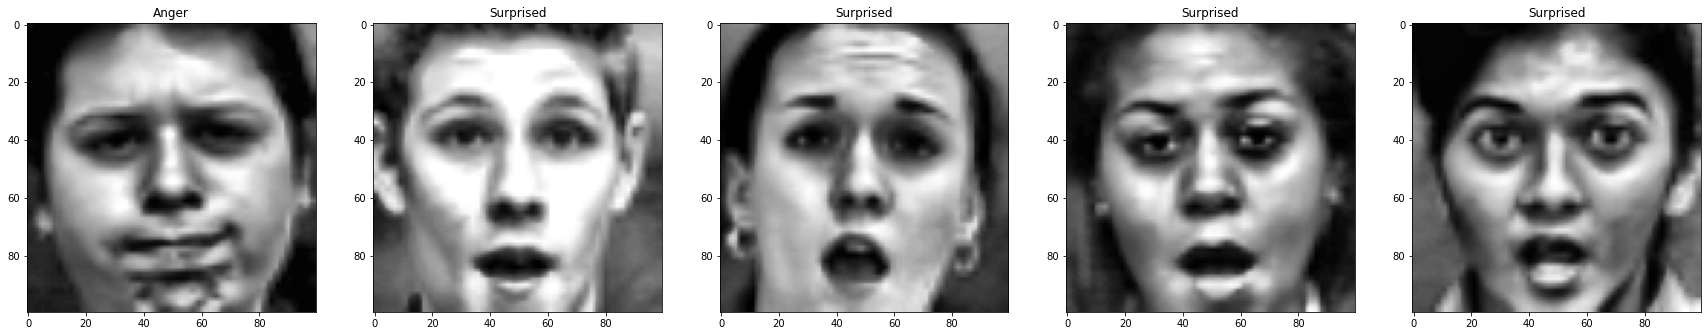

In [20]:
# print(np.unique(Y_new, return_counts=True))
# Xnew, Y_new = shuffle(Xnew, Y_new)

Y = np.array(Y)
# convert the labels to names from class_names
emotions = [class_names[int(i)] for i in Y]

show_images(X[:5], emotions[:5])
# print(Xnew.shape)
# print(Y.shape)


In [21]:
#Feature extraction
def detectemotion(roi_gray):
    wavelet = pywt.Wavelet('bior1.3')
    swt_img, pad_width = pad_img(roi_gray, wavelet.dec_lo)
    # we need to pad the image to make sure the dimensions are correct when we do the SWT

    # we remove 2 pixels from the image to make sure that max_level is bigger than 4
    # so that we can do the SWT decomposition with 4 levels
    swt_img = correct_dst_dim(swt_img)

    coeffsAll = pywt.swt2(swt_img, wavelet, level=4, start_level=0)

    dCoeff = []
    aCoeff = []

    for id, coeffs2 in enumerate(coeffsAll):

        LL, (HL, LH, HH) = coeffs2

        LL = wiener(LL, mysize=(3, 3))
        LH = wiener(LH, mysize=(3, 3))
        HL = wiener(HL, mysize=(3, 3))
        HH = wiener(HH, mysize=(3, 3))

        # we need to take the absolute value of the coefficients to make sure that we don't have negative values
        LL = np.abs(LL)
        LH = np.abs(LH)
        HL = np.abs(HL)
        HH = np.abs(HH)

        # LL -= np.min(LL)
        # LH -= np.min(LH)
        # HL -= np.min(HL)
        # HH -= np.min(HH)

        # we need to normalize the coefficients to make sure that we don't have values bigger than 255
        LL = (255)*(LL/np.max(LL))
        LH = (255)*(LH/np.max(LH))
        HL = (255)*(HL/np.max(HL))
        HH = (255)*(HH/np.max(HH))

        # we need to convert the coefficients to integers
        LL = np.fix(LL)
        LH = np.fix(LH)
        HL = np.fix(HL)
        HH = np.fix(HH)

        # remove the padding that we added before the SWT decomposition
        start = pad_width+pad_width//2
        end = -pad_width-pad_width//2-1
        LL = LL[start:end, start:end]
        LH = LH[start:end, start:end]
        HL = HL[start:end, start:end]
        HH = HH[start:end, start:end]

        coeffsAll[id] = (LL, LH, HL, HH)
        dCoeff.append((LH, HL, HH))
        aCoeff.append(LL)

    # %% [markdown]
    # 5) Apply wiener filter to all subbands by
    # equation 6 to reduce the high frequency
    # components effect.

    # %%
    coeffsAll = np.array(coeffsAll)
    dCoeff = np.array(dCoeff)
    aCoeff = np.array(aCoeff)
    coeffsAll = coeffsAll[::-1]
    dCoeff = dCoeff[::-1]
    aCoeff = aCoeff[::-1]

    # 6) Estimate the local energy in each
    # coefficient of detailed subbands by
    # equation 8.

    E = dCoeff**2

    # 7) For each subband, calculate the mean
    # local energy wavelet subband and
    # maximum local energy wavelet subband
    # using equation 9 & 10.
    filter = np.ones((3, 3))
    LEmax = E
    LEmu = E
    for i in range(4):
        for j in range(3):
            LEmu[i, j] = ndimage.uniform_filter(LEmu[i, j], size=3)
            # To get the maxima of the local energy, we dilate the local energy
            LEmax[i, j] = dilation(LEmax[i, j], filter)

    LEmax = (255)*(LEmax/np.max(LEmax))
    LEmu = (255)*(LEmu/np.max(LEmu))

    # 8) Evaluate pixel level fusion to the local
    # energy wavelet subbands to obtain a
    # combination set of subbands Skj(a,b)
    # (k=1,2…..,6 & j=1,2,3,4) by equations
    # 11-14.

    # %%
    # Equations from 12 to 14
    u = np.zeros((4, 1))
    v = np.zeros((4, 1))
    w = np.zeros((4, 1))
    for j in range(4):
        u[j] = np.sum(0.5*(1+np.corrcoef(coeffsAll[j][0], coeffsAll[j][1])))
        v[j] = np.sum(0.5*(1+np.corrcoef(coeffsAll[j][0], coeffsAll[j][2])))
        w[j] = np.sum(0.5*(1+np.corrcoef(coeffsAll[j][0], coeffsAll[j][3])))

    # %%
    # Equation 11
    Skj = np.zeros((6, 4, E.shape[2], E.shape[3]))
    for j in range(4):
        Skj[0, j] = u[j]*LEmu[j, 0]+v[j]*LEmu[j, 1]
        Skj[1, j] = u[j]*LEmu[j, 0]+w[j]*LEmu[j, 2]
        Skj[2, j] = v[j]*LEmu[j, 1]+w[j]*LEmu[j, 2]
        Skj[3, j] = u[j]*LEmax[j, 0]+v[j]*LEmax[j, 1]
        Skj[4, j] = u[j]*LEmax[j, 0]+w[j]*LEmax[j, 2]
        Skj[5, j] = v[j]*LEmax[j, 1]+w[j]*LEmax[j, 2]

    Skj = (255)*(Skj/np.max(Skj))
    # %% [markdown]
    # 9) Calculate the entropy value of all
    # subbands using equation 15. The
    # selections of subbands are made by the
    # consideration of maximal entropy
    # values. Se(a,b) (e=1,2….,15)

    # %%
    # shannon entropy from equation 15
    H = np.zeros((6, 4))
    for k in range(6):
        for j in range(4):
            H[k, j] = shannon_entropy(Skj[k, j])

    H = H.flatten()
    H_id = H.argsort()[::-1]

    Se = Skj.reshape((24, E.shape[2], E.shape[3]))
    Se = Se[H_id[:15]]

    Se = (255)*(Se/np.max(Se))
    # %% [markdown]
    # 10)Apply 8x8 block dct to all selected
    # subbands and the dc coefficient obtained
    # in each block alone is retained so that the
    # size of each subband is changed to
    # Sr(m,n). Here mxn = d<<axb, d is the
    # number of dc coefficients obtained in
    # each subband.

    Sr = np.zeros((15, E.shape[2], E.shape[3]))
    for i in range(15):
        Sr[i] = dct(Se[i], norm='ortho')

    # osize= (Se.shape[1] - 8)//8+1

    # Sr = np.zeros((15,osize,osize))
    # k=8
    # for r in range(15):
    #     for i in range(osize):
    #     # Iterate over the columns
    #         for j in range(osize):
    #             # img[i, j] = individual pixel value
    #             # Get the current matrix

    #             mat = Se[r, i:i+k, j:j+k]

    #             # Apply the convolution - element-wise multiplication and summation of the result
    #             # Store the result to i-th row and j-th column of our convolved_img array
    #             Sr[r, i, j] = dct(mat.flatten())[0]

    # %% [markdown]
    # 11) The statistical parameters such as mean,
    # standard deviation, covariance, median,
    # energy, skewness and kurtosis are
    # estimated from each subband and is
    # switched to one dimensional vector with
    # size of 1x105 (seven parameters from 15
    # subbands 7x15=105) which forms
    # feature vector Fimg

    # %%
    Fimg = np.zeros((15, 7))
    for r in range(15):
        Fimg[r, 0] = np.mean(Sr[r])
        Fimg[r, 1] = np.std(Sr[r])
        Fimg[r, 2] = np.var(Sr[r])
        Fimg[r, 3] = np.median(Sr[r])
        Fimg[r, 4] = np.sum(np.square(Sr[r]))
        Fimg[r, 5] = skew(Sr[r], axis=None)
        Fimg[r, 6] = kurtosis(Sr[r], axis=None)

    return Fimg.flatten()


In [22]:

#importing the pickle model
import pickle

with open('/Users/mohamedmehrez/Documents/study-spring-2023/GraduationProject/FacialEmotionRecognition/GraduationProject/Project/Emotion recognition models/IP_2_1_2023/Emotion_Detection/model85.pkl', 'rb') as file:
    model = pickle.load(file)



/Users/mohamedmehrez/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator SVC from version 1.1.3 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [23]:
x=[]
count=0
# Xnew=np.array(Xnew)
# print(Xnew.shape)
for i in X:
    count+=1
    x.append(detectemotion(i))
x=np.array(x)

/Users/mohamedmehrez/opt/anaconda3/lib/python3.8/site-packages/scipy/signal/_signaltools.py:1625: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/Users/mohamedmehrez/opt/anaconda3/lib/python3.8/site-packages/scipy/signal/_signaltools.py:1625: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


In [24]:
from sklearn.decomposition import PCA



xnew = []


temp = x.copy()

for i in temp:
    xnew.append(i.flatten())

xnew = np.array(xnew)
# print(xnew.shape)
# for each column in xnew, normalize it
mean, variance = np.zeros((105,)), np.zeros((105,))


for i in range(len(xnew[0])):
    mean[i] = np.mean(xnew[:, i])
    variance[i] = np.std(xnew[:, i])
    xnew[:, i] = (xnew[:, i] - np.mean(xnew[:, i])) / np.std(xnew[:, i])
pca = PCA(n_components=35)

# print(xnew.shape)
pca.fit(xnew)
Fimg = pca.transform(xnew)

# print(Fimg.shape)

# xnew = np.array(xnew)


In [25]:
from sklearn.decomposition import PCA
def faceEmotion(detected_face):
    input_image = cv2.imread(
        detected_image_path)

    #preprocess
    preprocessed_img=preprocess(detected_face)
#     show_images([preprocessed_img])

    #Feature extraction
    features = detectemotion(preprocessed_img)



    #normalization
    for i in range(len(features)):
        features[i] = (features[i] - np.mean(features)) / np.std(features)

 

#     print(features.shape)
    #reducing the features dimensions using PCA
    pca = PCA(n_components=35)
    pca.fit(xnew)
    features = pca.transform([features.flatten()])

    #features=features.reshape(1, -1)

    # Predict the emotion
    prediction = model.predict(np.array(features))
    print('predicted emotion: ',class_names[(int)(model.predict(features))])

    return class_names[(int)(model.predict(features))]
    #cv.imshow('Face',cv.imread('CapturedFace.png')) 
    #show_images([detected_face])

In [26]:
import math
import json

# REQUEST is the http request sent to the endpoints,
# it's initialized to prevent error in running the notebook
REQUEST = json.dumps({
    'path' : {},
    'args' : {}
})

{"imageFileName": null, "imageFolderName": null}


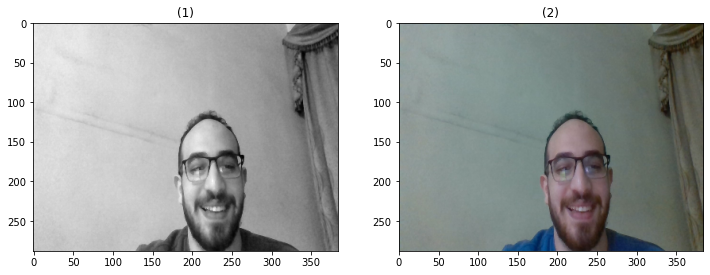

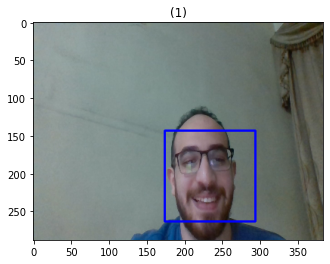

predicted emotion:  Anger


In [27]:
# GET /convert
req = json.loads(REQUEST)
args = req['args']
# image_Path=""
if 'imageFileName' not in args  and 'imageFolderName' not in args:
    print(json.dumps({'imageFileName': None,'imageFolderName':None}))
else:
    # Note the [0] when retrieving the argument.
    # ThiPas is because you could potentially pass multiple angles.
    imageFileName = args['imageFileName'][0]
    imageFolderName = args['imageFolderName'][0]
#     voicePath=args['voicePath'][0] #voice file path
   
    detected_face, detected_image_path = detect_face(imageFileName,imageFolderName)
    # call speech emotion
    output=faceEmotion(detected_face)
    print(json.dumps({'emotion': output,'path': str(args['imageFileName'][0])+"/"+str(args['imageFolderName'][0])}))
    
detected_face, detected_image_path = detect_face("test","WIN_20221231_22_23_57_Pro.jpg")
output=faceEmotion(detected_face)


In [28]:

###Voice reading#######
import io
import librosa
import urllib.request


with urllib.request.urlopen("https://firebasestorage.googleapis.com/v0/b/emodetector-fad51.appspot.com/o/test%2Ftest_4.mp3?alt=media") as url:
    data = io.BytesIO(url.read())
y, sr = librosa.load(data)
print(y)

[]
